## **Youtube Spam Comments Classification**

<br></br>
<h3><b> Loading Python Libraries </b></h3>

In [1]:
# Let's import the required python packages
import re
import nltk
import string
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import missingno as msno
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from keras.layers import Dropout
from nltk.corpus import stopwords
from sklearn import model_selection
from keras.models import Sequential
from nltk.tokenize import word_tokenize
from keras.callbacks import EarlyStopping
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from tensorboard.plugins.hparams import api as hp
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Embedding, Flatten, Conv1D, GlobalMaxPooling1D

%matplotlib inline
# plt.style.use('seaborn-dark')
plt.style.context('grayscale')

nltk.download('punkt')
nltk.download("stopwords")

# Let's define a seed
seed = 1
np.random.seed = seed

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<br></br>
### **Importing the Data**

In [2]:
# Let's fetch the youtube spam comments dataset into a data_frame
psy_df = pd.read_csv('Youtube01-Psy.csv')
katy_df = pd.read_csv('Youtube02-KatyPerry.csv')
eminem_df = pd.read_csv('Youtube04-Eminem.csv')
shakira_df = pd.read_csv('Youtube05-Shakira.csv')
lmfao_df = pd.read_csv('Youtube03-LMFAO.csv')

# Let's concat all the data into a single dataframe
comments_dataframe = pd.concat([psy_df, katy_df, eminem_df, shakira_df, lmfao_df])

# Let's take a quick look at the shape of the dataframe
print("Youtube Spam Comments data shape -->", comments_dataframe.shape)
print()

# Let's take a brief look at the contents of the dataframe
comments_dataframe.head()

Youtube Spam Comments data shape --> (1956, 5)



,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


<br></br>
<h3><b> Gaining Insights from Data </b></h3>

In [3]:
# Let's obtain a brief overview of the spam comments dataframe
comments_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 437
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   CLASS       1956 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 91.7+ KB


<br></br>
### **See how many missing data points we have**

In [4]:
comments_dataframe.isnull().sum()

COMMENT_ID      0
AUTHOR          0
DATE          245
CONTENT         0
CLASS           0
dtype: int64

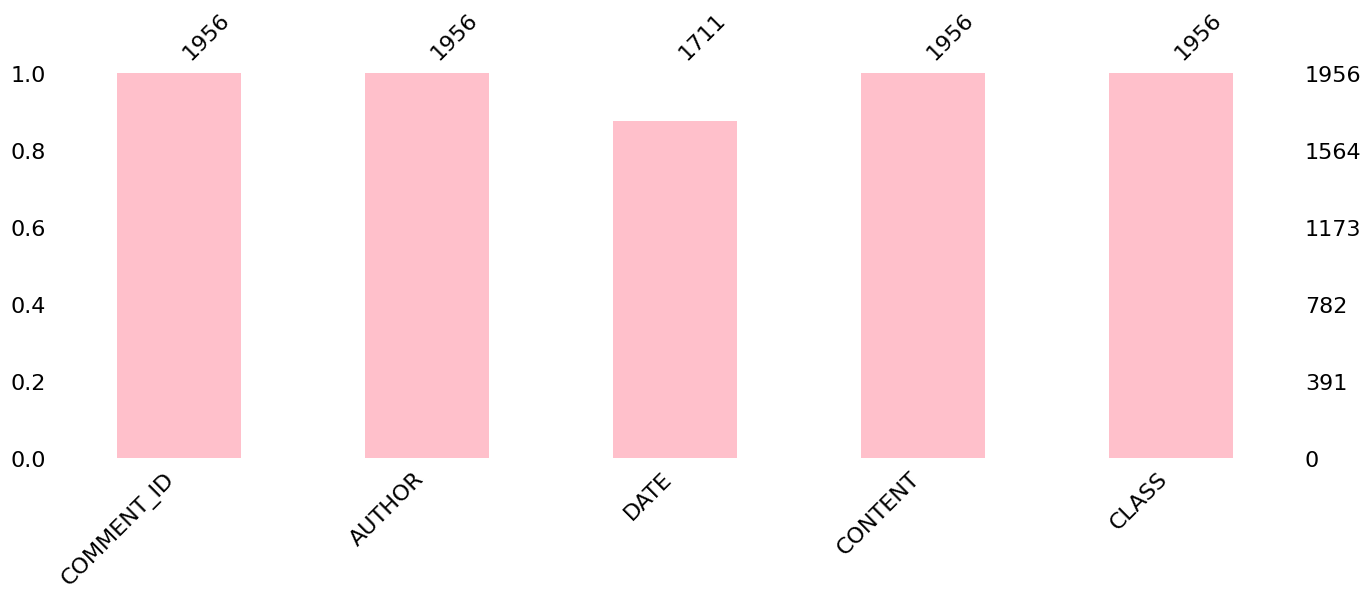

In [5]:
msno.bar(comments_dataframe, figsize = (16,5),color = "pink")
plt.show()

<br></br>
### **Data Cleaning**

In [6]:
## Let's drop the unnecessary columns like COMMENT_ID, AUTHOR and DATE
comments_dataframe.drop(["COMMENT_ID", "AUTHOR", "DATE"], axis=1, inplace=True)

# Let's take a quick look at the shape of the dataframe
print("Youtube Spam Comments data shape -->", comments_dataframe.shape)
print()

# Let's take a brief look at the contents of the dataframe
comments_dataframe.head()

Youtube Spam Comments data shape --> (1956, 2)



,CONTENT,CLASS
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1


<br></br>
<h3><b> Exploratory Data Analysis</b></h3>

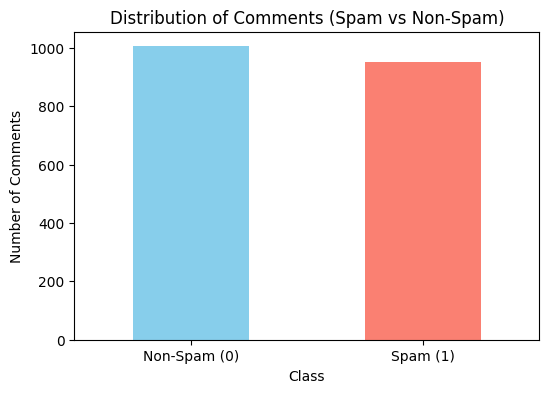

In [7]:
# Let's plot the count of spam and non-spam comments
plt.figure(figsize=(6, 4))
comments_dataframe['CLASS'].value_counts().plot(kind="bar", color=["skyblue", "salmon"])
plt.title("Distribution of Comments (Spam vs Non-Spam)")
plt.xlabel("Class")
plt.ylabel("Number of Comments")
plt.xticks(ticks=[0, 1], labels=["Non-Spam (0)", "Spam (1)"], rotation=0)
plt.show()

<br></br>
<h3><b> Data Processing</b></h3>

In [8]:
def text_processing(text_message):
    # Patterns from previous steps
    email_regex = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
    url_regex = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\'(),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    money_regex = re.compile(r'£|\$')
    phone_regex = re.compile(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b')
    number_regex = re.compile(r'\b\d+\b')

    # New patterns
    youtube_watch_regex = re.compile(r'watch\?v=[\w-]+')
    dot_com_regex = re.compile(r'\.\s*com')
    multiple_exclamation_regex = re.compile(r'!{2,}')
    multiple_fullstop_regex = re.compile(r'\.{2,}')
    emoticon_regex = re.compile(r':\s*[DP]|\^\_\^|-\_-\﻿')
    unnecessary_symbols_regex = re.compile(r'[\^<>-]+|▬+|ஜ۩۞۩ஜ+')
    m_v_regex = re.compile(r'\(강남스타일\) M/V:')
    emojis_regex = re.compile(r'[\u263a-\U0001f645]')
    laughing_emoji_regex = re.compile(r':\s*\)')
    tilde_regex = re.compile(r'~+')
    at_symbol_regex = re.compile(r'@')
    hyperurl_regex = re.compile(r'hyperurl\.co/[\w-]+')

    # Apply replacements
    processed = re.sub(email_regex, 'emailaddress', text_message)
    processed = re.sub(url_regex, 'webaddress', processed)
    processed = re.sub(money_regex, 'moneysymb', processed)
    processed = re.sub(phone_regex, 'phonenumber', processed)
    processed = re.sub(number_regex, 'numbr', processed)

    # Apply new replacements
    processed = re.sub(youtube_watch_regex, 'youtubevideo', processed)
    processed = re.sub(dot_com_regex, '.com', processed)
    processed = re.sub(multiple_exclamation_regex, '!', processed)
    processed = re.sub(multiple_fullstop_regex, '.', processed)
    processed = re.sub(emoticon_regex, '', processed)
    processed = re.sub(unnecessary_symbols_regex, '', processed)
    processed = re.sub(m_v_regex, '', processed)
    processed = re.sub(emojis_regex, '', processed)
    processed = re.sub(laughing_emoji_regex, '', processed)
    processed = re.sub(tilde_regex, '', processed)
    processed = re.sub(at_symbol_regex, '', processed)
    processed = re.sub(hyperurl_regex, 'webaddress', processed)
    processed = processed.replace(r'[^\w\d\s]', ' ')

    # Replace whitespace between terms with a single space
    processed = processed.replace(r'\s+', ' ')

    # Remove leading and trailing whitespace
    processed = processed.replace(r'^\s+|\s+?$', '')

    return processed.lower()

In [9]:
# Apply the data pre-processing function to the 'CONTENT' column
comments_dataframe['processed_content'] = comments_dataframe['CONTENT'].apply(text_processing)

# Let's take a quick look at the shape of the dataframe
print("Youtube Spam Comments data shape -->", comments_dataframe.shape)
print()

# Let's take a brief look at the contents of the dataframe
comments_dataframe.head()

Youtube Spam Comments data shape --> (1956, 3)



,CONTENT,CLASS,processed_content
0,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this you[tube] channel: ..."
1,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,youtubevideo check this out .


In [10]:
# Let's define stop words and punctuations
punctuations = list(string.punctuation)
stop_words = set(stopwords.words("english"))

# Let's remove the stop words from text messages
def remove_stopwords_punctuations(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations]
    filtered_text = ' '.join(tokens)
    return filtered_text

# Apply the function to the 'processed_content' column
comments_dataframe["processed_content"] = comments_dataframe["processed_content"].apply(remove_stopwords_punctuations)

In [11]:
# Let's create bag-of-words
all_words = []

for message in comments_dataframe["processed_content"]:
    words = word_tokenize(message)
    for w in words:
        all_words.append(w)

all_words = nltk.FreqDist(all_words)

In [12]:
# Let's print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(5)))

# Let's use the 1500 most common words as features
word_features = list(all_words.keys())[:1500]

Number of words: 3899
Most common words: [('numbr', 785), ('check', 569), ('video', 306), ('song', 281), ('webaddress', 252)]


In [13]:
def find_features(message):
    words = word_tokenize(message)
    features = {}
    for word in word_features:
        features[word] = (word in words)

    return features

In [14]:
messages = list(zip(comments_dataframe["processed_content"], comments_dataframe["CLASS"]))


np.random.shuffle(messages)

# call find_features function for each SMS message
featuresets = [(find_features(text), label) for (text, label) in messages]

In [15]:
# Let's split the data into train and test data
training, testing = model_selection.train_test_split(featuresets, test_size = 0.25, random_state=seed)

<br></br>
<b><h3> Comparing Performance of Different Models </h3></b>

In [16]:
def train_and_evaluate_classifiers(training, testing):
    # Define models to train
    names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
             "Naive Bayes", "SVM Linear"]

    classifiers = [
        KNeighborsClassifier(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        LogisticRegression(),
        SGDClassifier(max_iter=100),
        MultinomialNB(),
        SVC(kernel='linear')
    ]

    models = zip(names, classifiers)
    model_names = []
    results = []

    for name, model in models:
        nltk_model = SklearnClassifier(model)
        nltk_model.train(training)
        accuracy = nltk.classify.accuracy(nltk_model, testing) * 100
        print("{} Accuracy: {}".format(name, accuracy))
        model_names.append(name)
        results.append(accuracy)

    # Return the results
    return model_names, results

In [17]:
# Let's train and evaluate the classifiers
model_names, results = train_and_evaluate_classifiers(training, testing)

K Nearest Neighbors Accuracy: 85.88957055214725
Decision Tree Accuracy: 94.27402862985686
Random Forest Accuracy: 95.29652351738241
Logistic Regression Accuracy: 95.50102249488752
SGD Classifier Accuracy: 93.4560327198364
Naive Bayes Accuracy: 86.9120654396728
SVM Linear Accuracy: 94.27402862985686


<br></br>
<b><h3> Hyperparameter Tuning with Grid Search </h3></b>

In [18]:
from sklearn.model_selection import GridSearchCV

# Let's define the parameter grid for parameter optimization
param_grid = {
    'n_estimators': [100, 200, 300, 400, 600, 800, 1000, 1200],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
    # Add more parameters here if needed
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
nltk_model = SklearnClassifier(grid_search)

# Let's train the nltk model using the training set
nltk_model.train(training)
best_model = nltk_model._clf.best_estimator_

# Let's evaluate the accuracy of the best model on the testing set
accuracy = nltk.classify.accuracy(nltk_model, testing)

print(f"Best Model: {best_model}")
print(f"Accuracy: {accuracy * 100}%")

Fitting 3 folds for each of 864 candidates, totalling 2592 fits
Best Model: RandomForestClassifier(bootstrap=False, min_samples_split=5, n_estimators=400)
Accuracy: 96.11451942740287%


<br></br>
<b><h3> Neural Network Implementation </h3></b>

<b><h5> Feed Forward Neural Network(ANN) </h5></b>

In [19]:
def tokenize_and_pad_sequences(texts, tokenizer, is_train=True, max_seq_len=None, padding_type='post'):
    # Let's tokenize the sentences
    sequences = tokenizer.texts_to_sequences(texts)

    # Let's pad the sequences to max-length
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_seq_len, padding=padding_type)

    return padded_sequences


In [20]:
def preprocess_text_data(comments_dataframe):
    df = comments_dataframe.copy()

    # Let's split the data
    content = df["processed_content"]
    labels = df["CLASS"]

    content_train, content_test, labels_train, labels_test = model_selection.train_test_split(content, labels, test_size=0.30, shuffle=True, random_state=1)

    # Let's create a tokenizer and fit sentences
    content_tokenizer = tf.keras.preprocessing.text.Tokenizer()
    content_tokenizer.fit_on_texts(content_train)
    vocab_size = len(content_tokenizer.word_index) + 1
    print(f"Vocabulary Size: {vocab_size}")

    # Let's create tokens for train sentences
    content_train_seq = tokenize_and_pad_sequences(content_train, content_tokenizer, is_train=True)
    max_seq_length = content_train_seq.shape[1]
    print(f"Max Sequence Length(Train Data): {max_seq_length}")

    # Let's create tokens for test sentences
    content_test_seq = tokenize_and_pad_sequences(content_test, content_tokenizer, max_seq_len=max_seq_length)
    print(f"Max Sequence Length(Test Data): {max_seq_length}")


    return content_train_seq, content_test_seq, labels_train, labels_test, vocab_size, max_seq_length


In [21]:
# Let's call preprocess_text_data to get training and evaluation data samples
X_train, X_test, y_train, y_test, _, _ = preprocess_text_data(comments_dataframe)

Vocabulary Size: 2994
Max Sequence Length(Train Data): 114
Max Sequence Length(Test Data): 114


In [22]:
# Let's define the sequential model
model_text_classifier = Sequential([
    # Embedding layer
    Embedding(input_dim=3821, output_dim=300, input_length=X_train.shape[1]),

    # Flatten the output of the embedding layer
    Flatten(),

    # Dense layers
    Dense(64, activation='relu'),
    Dropout(0.7),

    Dense(128, activation='relu'),
    Dropout(0.7),


    # Output layer
    Dense(1, activation='sigmoid')
])

# Let's compile the model
model_text_classifier.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Let's print model summary
model_text_classifier.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 114, 300)          1146300   
                                                                 
 flatten (Flatten)           (None, 34200)             0         
                                                                 
 dense (Dense)               (None, 64)                2188864   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1

In [23]:
# Let's define early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Increased patience
    restore_best_weights=True
)

# Let's train the model
history_text_classifier = model_text_classifier.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    callbacks=[early_stopping_callback]
)

Epoch 1/10
35/35 [==============================] - 3s 59ms/step - loss: 0.7476 - accuracy: 0.5014 - auc: 0.4820 - val_loss: 0.6925 - val_accuracy: 0.5036 - val_auc: 0.5145
Epoch 2/10
35/35 [==============================] - 2s 67ms/step - loss: 0.6910 - accuracy: 0.5370 - auc: 0.5457 - val_loss: 0.6858 - val_accuracy: 0.5036 - val_auc: 0.8264
Epoch 3/10
35/35 [==============================] - 2s 55ms/step - loss: 0.6869 - accuracy: 0.5215 - auc: 0.5091 - val_loss: 0.6794 - val_accuracy: 0.5036 - val_auc: 0.7085
Epoch 4/10
35/35 [==============================] - 2s 47ms/step - loss: 0.6596 - accuracy: 0.5215 - auc: 0.6131 - val_loss: 0.6219 - val_accuracy: 0.5036 - val_auc: 0.9429
Epoch 5/10
35/35 [==============================] - 2s 47ms/step - loss: 0.5356 - accuracy: 0.6155 - auc: 0.8736 - val_loss: 0.4296 - val_accuracy: 0.9161 - val_auc: 0.9783
Epoch 6/10
35/35 [==============================] - 2s 47ms/step - loss: 0.3914 - accuracy: 0.9233 - auc: 0.9720 - val_loss: 0.3726 - v

In [24]:
# Let's test the model with best weights avialble from callback
test_performance = model_text_classifier.evaluate(X_test, y_test, verbose=0)

# Let's extract the accuracy and AUC from the results
accuracy = test_performance[1] * 100
auc_score = test_performance[2]

# Let's display the metrics in a formatted way
print(f"Test Accuracy: {accuracy:.4f}%")
print(f"Test AUC Score: {auc_score:.3f}")

Test Accuracy: 94.2078%
Test AUC Score: 0.964


<br></br>
<b><h5> Convolution Neural Network(CNN) </h5></b>

In [25]:
# Let's define the sequential model of convolution layers
model_conv = Sequential()
# Embedding layer
model_conv.add(Embedding(input_dim=3821, output_dim=300, input_length=X_train.shape[1]))
# 1D convolution layer
model_conv.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
# Pooling layer
model_conv.add(GlobalMaxPooling1D())
# Dense layers
model_conv.add(Dense(10, activation='relu'))
model_conv.add(Dense(1, activation='sigmoid'))

# Let's compile the model
model_conv.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Let's print model summary
model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 114, 300)          1146300   
                                                                 
 conv1d (Conv1D)             (None, 110, 128)          192128    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1339729 (5.11 MB)
Trainable params: 1339729 (5.11 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [26]:
# Let's define early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Increased patience
    restore_best_weights=True
)

# Let's train the model
history_conv_text_classifier = model_conv.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    callbacks=[early_stopping_callback]
)

Epoch 1/10
35/35 [==============================] - 5s 122ms/step - loss: 0.6181 - accuracy: 0.7087 - auc: 0.8739 - val_loss: 0.4485 - val_accuracy: 0.9197 - val_auc: 0.9818
Epoch 2/10
35/35 [==============================] - 5s 153ms/step - loss: 0.2381 - accuracy: 0.9461 - auc: 0.9837 - val_loss: 0.1520 - val_accuracy: 0.9380 - val_auc: 0.9884
Epoch 3/10
35/35 [==============================] - 4s 115ms/step - loss: 0.0674 - accuracy: 0.9826 - auc: 0.9979 - val_loss: 0.1258 - val_accuracy: 0.9489 - val_auc: 0.9920
Epoch 4/10
35/35 [==============================] - 4s 115ms/step - loss: 0.0272 - accuracy: 0.9918 - auc: 0.9997 - val_loss: 0.1255 - val_accuracy: 0.9526 - val_auc: 0.9927
Epoch 5/10
35/35 [==============================] - 5s 148ms/step - loss: 0.0145 - accuracy: 0.9973 - auc: 0.9999 - val_loss: 0.1351 - val_accuracy: 0.9489 - val_auc: 0.9909
Epoch 6/10
35/35 [==============================] - 4s 114ms/step - loss: 0.0080 - accuracy: 0.9982 - auc: 1.0000 - val_loss: 0.14

In [27]:
# Let's test the CNN model with best weights avialble from callback
test_performance = model_conv.evaluate(X_test, y_test, verbose=0)

# Let's extract the accuracy and AUC from the results
accuracy = test_performance[1] * 100
auc_score = test_performance[2]

# Let's display the metrics in a formatted way
print(f"CNN Test Accuracy: {accuracy:.4f}%")
print(f"CNN Test AUC Score: {auc_score:.3f}")

CNN Test Accuracy: 95.4003%
CNN Test AUC Score: 0.988
